In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import re
import seaborn as sns
from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
df = pd.read_csv("synonyms.csv")

df.head()

,lemma,part_of_speech,synonyms
0,.22-caliber,adjective,.22 caliber;.22 calibre;.22-calibre
1,.22-calibre,adjective,.22 caliber;.22-caliber;.22 calibre
2,.22 caliber,adjective,.22-caliber;.22 calibre;.22-calibre
3,.22 calibre,adjective,.22 caliber;.22-caliber;.22-calibre
4,.38-caliber,adjective,.38 caliber;.38 calibre;.38-calibre


In [5]:
ps = PorterStemmer()
df["stemmed"] = df["lemma"].apply(lambda w: ps.stem(w) if isinstance(w, str) else None)

In [26]:
remove_stemming = df[df.duplicated(subset=["stemmed","part_of_speech"]) == False]

In [27]:
remove_stemming["split"] = remove_stemming["synonyms"].str.replace("|",";").apply(lambda x: x.split(";") if isinstance(x, str) else None)

C:\Users\Vass\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Need to pair up words that are synonyms.

In [28]:
pairs = []
only_with_syns = remove_stemming[remove_stemming["synonyms"].isna() ==False]

# not interested in lemmas that are numbers
for lem in remove_stemming[remove_stemming["lemma"].str.isnumeric() == False]["lemma"]:
    
    mask = only_with_syns.split.apply(lambda x: lem in x)
    df1 = only_with_syns[mask]
    if df1.shape[0] > 0:
        
        for comp_lem in df1["lemma"]:
            if lem != comp_lem:
                comp_pair = [lem, comp_lem]
                pairs.append(comp_pair)

In [29]:
len(pairs)
# 367754 with numbers included
# 367024 without numbers v1
# 250440 after stemming

250440

In [33]:
np_pairs = np.array(pairs)
edges_raw = pd.DataFrame(np_pairs)

In [34]:
edges_raw.shape

(250440, 2)

Now that all pairs are in a dataframe must get rid of duplicates.

In [31]:
df1 = pd.DataFrame(np.sort(edges_raw[[0,1]], axis=1))

edges_raw1 = edges_raw[~df1.duplicated()]

In [32]:
edges_raw1.to_csv("edges.csv")

In [213]:
# Convert columns into list of tuples
tup_edges = list(zip(edges_raw1[0], edges_raw1[1]))

# list of nodes and associated connections
edges = [t for t in (set(tuple(i) for i in tup_edges))]

In [214]:
# create networkx graph
Gx = nx.Graph()
Gx.add_edges_from(edges)


In [218]:
degrees = pd.DataFrame([[tup[0], tup[1]]for tup in nx.degree(Gx)])

degrees.rename(mapper={0:"Node ID",1:"Degrees"},inplace=True,axis=1)
degrees.sort_values("Degrees",inplace=True)
degrees.reset_index(inplace=True,drop=True)
degrees.head()

,Node ID,Degrees
0,anthropomorphise,1
1,negro spiritual,1
2,place-worship,1
3,topolatry,1
4,olecranon,1


[Text(0, 0.5, 'Percentage of Nodes'),
 Text(0.5, 0, 'Degrees'),
 Text(0.5, 1.0, 'Degree Distribution')]

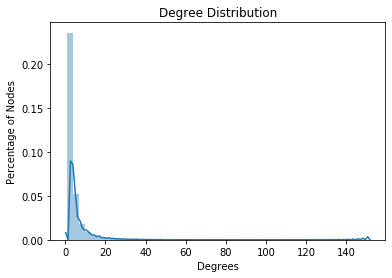

In [222]:
dist = sns.distplot(degrees["Degrees"])
dist.set(xlabel='Degrees', ylabel='Percentage of Nodes',title="Degree Distribution")

In [223]:
degrees.sort_values("Degrees",ascending=False)

,Node ID,Degrees
85712,pass,151
85711,break,147
85710,get,144
85709,take,141
85708,make,129
...,...,...
21032,tennis,1
21033,bullfrog,1
21034,rana catesbeiana,1
21035,creek bed,1
